```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
```

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
from tqdm import tqdm, tqdm_notebook
import pickle

### Download data

In [0]:
l = []
for el in list(np.array(range(50)).astype(str)):
  l.append(el.zfill(2))

In [0]:
main_path = '/content/drive/My Drive/Kaggle/DeepFake/DeepFakeKaggleChallenge/DataSample/'
main_path_bash = '/content/drive/My\ Drive/Kaggle/DeepFake/DeepFakeKaggleChallenge/DataSample/'

In [0]:
for n in l:
  os.system('wget --load-cookies /content/cookies.txt https://www.kaggle.com/c/16880/datadownload/dfdc_train_part_'+n+'.zip')
  print('1')
  os.system('unzip dfdc_train_part_'+n+'.zip -d /content/')
  print('2')
  os.system('rm /content/dfdc_train_part_'+n+'.zip')
  print('3')
  #os.system('rm -r /content/drive/My\ Drive/Kaggle/DeepFake/DeepFakeKaggleChallenge/DataSample/dfdc_train_part_'+n)
  #print('4')
  os.system('mv /content/dfdc_train_part_'+n+' /content/drive/My\ Drive/Kaggle/DeepFake/DeepFakeKaggleChallenge/DataSample/')
  print(n)
  print('-------')

In [0]:
folders = list(folders[np.array([string[-3:] for string in np.array(os.listdir(main_path))])!='zip'])


In [0]:
os.listdir(main_path+folders[0]+'/')#+df.iloc[i]['name'][1:]+'.mp4'+
                  #' '+main_path_bash+'ExtractedAudioSample/'+df.iloc[i].folder+'/'+df.iloc[i]['name'][1:]+'/audio.wav')

In [0]:
r = 0
for d in folders:
  files = os.listdir(main_path+d)
  for f in files:
    try:
      b = os.system('ffmpeg -i '+main_path_bash+d+'/'+f+
                    ' '+main_path_bash+'ExtractedAudioSample/'+d+'/'+f+'/audio.wav')
    except:
      r += 1
      with open(main_path+'../Audio/unreadable.txt','a') as file:
        file.write(df.iloc[i].folder+','+df.iloc[i]['name'][1:]+'\n')


100%|██████████| 1961/1961 [43:28<00:00,  1.51it/s]


## Exctract fake by audio

In [0]:
path = '/content/drive/My Drive/Kaggle/DeepFake/DeepFakeKaggleChallenge/DataSample/ExtractedAudioSample/audios49/'

In [0]:
df = pd.read_json(path+'metadata.json')
df = df.transpose().reset_index().sort_values('index').reset_index(drop=True)

In [0]:
def check_fake_by_audio(a,b,sr=20000):
  audio_array_a, sample_rate = librosa.load(path+a+'/audio.wav', sr=sr)
  audio_array_b, sample_rate = librosa.load(path+b+'/audio.wav', sr=sr)
  if audio_array_a.shape==audio_array_b.shape:
    if np.array_equal(audio_array_a, audio_array_b):
      return 0
    else:
      return 1
  else:
    return 1

fake_by_audio = np.zeros(len(df))
for i in tqdm(range(len(df))):
  if df.loc[i,'label']=='FAKE':
    a = df.loc[i,'index'][:-4]
    b = df.loc[i,'original'][:-4]
    try:
      fake_by_audio[i]=check_fake_by_audio(a,b)
      #print(fake_by_audio[i],i)
    except:
      #print(os.path.basename(os.path.normpath(path))+', '+str(i)+', '+df.iloc[i]['index'][:-4]+'\n')
      with open('/content/drive/My Drive/Kaggle/DeepFake/errori.txt','a') as file:
        file.write(os.path.basename(os.path.normpath(path))+', '+str(i)+', '+df.iloc[i]['index'][:-4]+'\n')
        

100%|██████████| 3134/3134 [40:33<00:00,  1.34it/s]


In [0]:
df['fake_by_audio']=np.floor(fake_by_audio)
df.to_json(path+'/metadata_plus.json')

fk_p = df.groupby('label').count().loc['FAKE','index']/len(df)
fk_a_p = df.groupby('fake_by_audio').count().loc[1.0,'index']/len(df)

with open('/content/drive/My Drive/Kaggle/DeepFake/audio_stats.txt','a') as file:
  file.write(os.path.basename(os.path.normpath(path))+','+str(fk_p)+','+str(fk_a_p)+','+str(len(df))+'\n')

## Single Spectrum Analysis

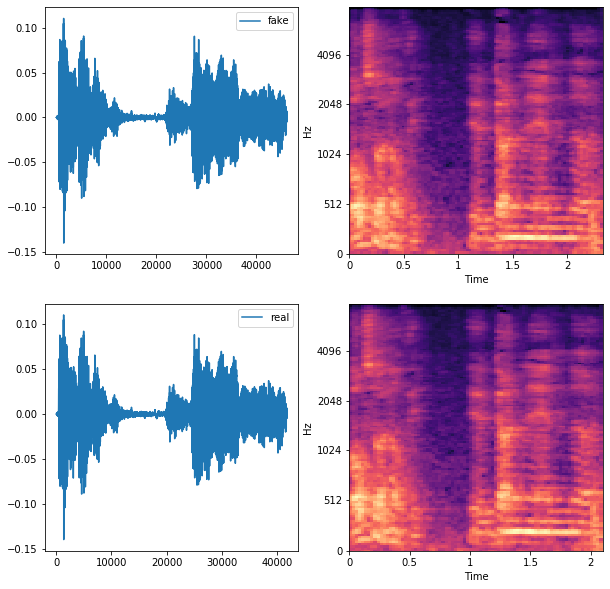

In [0]:
sr = 20000
idx = 538

fig,axes = plt.subplots(2,2, figsize=(10,10))

audio_array, sample_rate = librosa.load(path+df.loc[idx,'index'][:-4]+'/audio.wav')
axes[0,0].plot(audio_array,label='fake')
axes[0,0].legend()
#trim_audio_array, index = librosa.effects.trim(audio_array) #delete silence audio
S = librosa.feature.melspectrogram(y=audio_array, sr=sr)#, n_mels=128, fmax=8000)
S_dB_f = librosa.power_to_db(S, ref=np.max)

librosa.display.specshow(S_dB_f, x_axis='time',y_axis='mel', sr=sr,fmax=8000,ax=axes[0,1])

audio_array, sample_rate = librosa.load(path+df.loc[idx,'original'][:-4]+'/audio.wav', sr=sr)
axes[1,0].plot(audio_array,label='real')
axes[1,0].legend()
S = librosa.feature.melspectrogram(y=audio_array, sr=sr)
S_dB_r = librosa.power_to_db(S, ref=np.max)

librosa.display.specshow(S_dB_r, x_axis='time',y_axis='mel', sr=sr,fmax=8000,ax=axes[1,1])

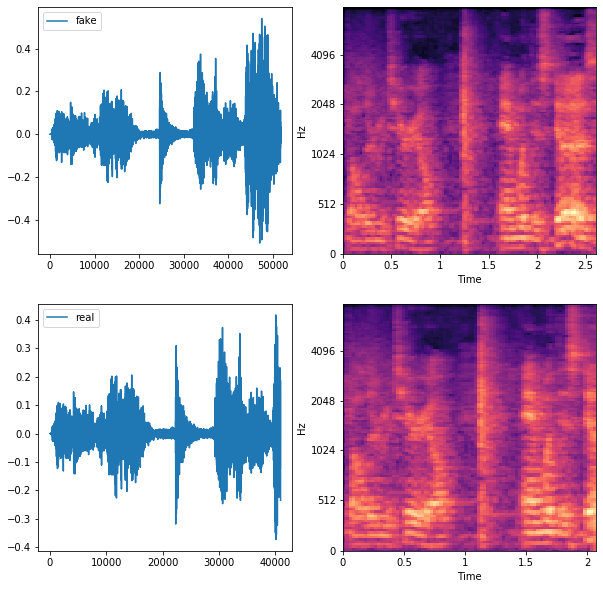

In [0]:
sr = 20000
idx = 932

fig,axes = plt.subplots(2,2, figsize=(10,10))

audio_array, sample_rate = librosa.load(path+df.loc[idx,'index'][:-4]+'/audio.wav')
axes[0,0].plot(audio_array,label='fake')
axes[0,0].legend()
#trim_audio_array, index = librosa.effects.trim(audio_array) #delete silence audio
S = librosa.feature.melspectrogram(y=audio_array, sr=sr)#, n_mels=128, fmax=8000)
S_dB_f = librosa.power_to_db(S, ref=np.max)

librosa.display.specshow(S_dB_f, x_axis='time',y_axis='mel', sr=sr,fmax=8000,ax=axes[0,1])

audio_array, sample_rate = librosa.load(path+df.loc[idx,'original'][:-4]+'/audio.wav', sr=sr)
axes[1,0].plot(audio_array,label='real')
axes[1,0].legend()
S = librosa.feature.melspectrogram(y=audio_array, sr=sr)
S_dB_r = librosa.power_to_db(S, ref=np.max)

librosa.display.specshow(S_dB_r, x_axis='time',y_axis='mel', sr=sr,fmax=8000,ax=axes[1,1])

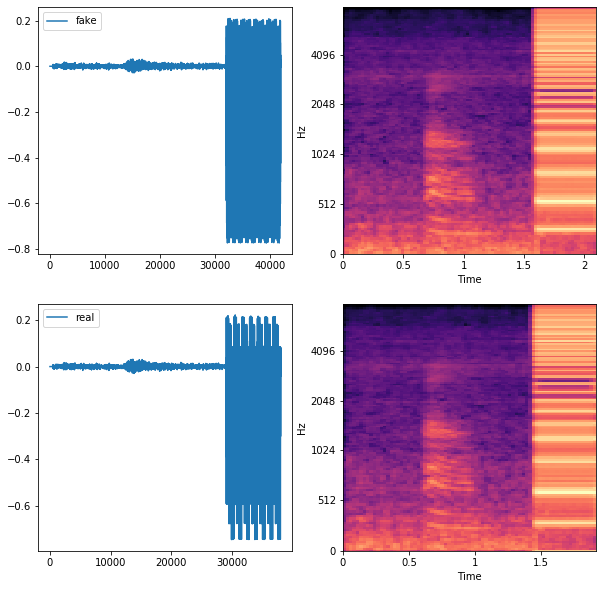

In [0]:
sr = 20000
idx = 138

fig,axes = plt.subplots(2,2, figsize=(10,10))

audio_array, sample_rate = librosa.load(path+df.loc[idx,'index'][:-4]+'/audio.wav')
axes[0,0].plot(audio_array,label='fake')
axes[0,0].legend()
#trim_audio_array, index = librosa.effects.trim(audio_array) #delete silence audio
S = librosa.feature.melspectrogram(y=audio_array, sr=sr)#, n_mels=128, fmax=8000)
S_dB_f = librosa.power_to_db(S, ref=np.max)

librosa.display.specshow(S_dB_f, x_axis='time',y_axis='mel', sr=sr,fmax=8000,ax=axes[0,1])

audio_array, sample_rate = librosa.load(path+df.loc[idx,'original'][:-4]+'/audio.wav', sr=sr)
axes[1,0].plot(audio_array,label='real')
axes[1,0].legend()
S = librosa.feature.melspectrogram(y=audio_array, sr=sr)
S_dB_r = librosa.power_to_db(S, ref=np.max)

librosa.display.specshow(S_dB_r, x_axis='time',y_axis='mel', sr=sr,fmax=8000,ax=axes[1,1])

## Dataset Creation

In [0]:
main_path = '/content/drive/My Drive/Kaggle/DeepFake/DeepFakeKaggleChallenge/DataSample/ExtractedAudioSample/'
main_path_bash = '/content/drive/My\ Drive/Kaggle/DeepFake/DeepFakeKaggleChallenge/DataSample/'

paths = os.listdir(main_path)

In [0]:
sr = 20000

features = []
labels = []
names = []
folders = []

for i in tqdm(range(len(paths))):
  data = pd.read_json(main_path+paths[i]+'/'+'metadata_plus.json')
  df = data[data.label.isin(['FAKE'])]
  df = df[df.fake_by_audio.isin([1])].drop_duplicates().reset_index(drop=True)

  for j in range(len(df)):
    try:
      audio_array, sample_rate = librosa.load(main_path+paths[i]+'/'+df['index'].iloc[j][:-4]+'/audio.wav',sr=sr)
      S_f = librosa.feature.melspectrogram(y=audio_array, n_mels=128, fmax=8000,sr=sr)
      S_dB_f = librosa.power_to_db(S_f, ref=np.max)

      audio_array, sample_rate = librosa.load(main_path+paths[i]+'/'+df['original'].iloc[j][:-4]+'/audio.wav',sr=sr)
      S_r = librosa.feature.melspectrogram(y=audio_array, n_mels=128, fmax=8000, sr=sr)
      S_dB_r = librosa.power_to_db(S_r, ref=np.max)

      features.append(S_dB_f)
      labels.append('FAKE')
      names.append(df['index'].iloc[j][:-4])
      folders.append(paths[i])        

      features.append(S_dB_r)
      labels.append('REAL')
      names.append(df['original'].iloc[j][:-4])
      folders.append(paths[i])

    except:

      try:
        os.system('rm '+main_path_bash+'ExtractedAudioSample/'+paths[i]+'/'+df['index'].iloc[j][:-4]+'/audio.wav')
        os.system('ffmpeg -i '+main_path_bash+'dfdc_train_part_'+paths[i][6:].zfill(2)+'/'+df['index'].iloc[j][:-4]+'.mp4 '+main_path_bash+'ExtractedAudioSample/'+paths[i]+'/'+df['index'].iloc[j][:-4]+'/audio.wav')

        os.system('rm '+main_path_bash+'ExtractedAudioSample/'+paths[i]+'/'+df['original'].iloc[j][:-4]+'/audio.wav')
        os.system('ffmpeg -i '+main_path_bash+'dfdc_train_part_'+paths[i][6:].zfill(2)+'/'+df['original'].iloc[j][:-4]+'.mp4 '+main_path_bash+'ExtractedAudioSample/'+paths[i]+'/'+df['original'].iloc[j][:-4]+'/audio.wav')

        audio_array, sample_rate = librosa.load(main_path+paths[i]+'/'+df['index'].iloc[j][:-4]+'/audio.wav',sr=sr)
        S_f = librosa.feature.melspectrogram(y=audio_array, n_mels=128, fmax=8000,sr=sr)
        S_dB_f = librosa.power_to_db(S_f, ref=np.max)

        audio_array, sample_rate = librosa.load(main_path+paths[i]+'/'+df['original'].iloc[j][:-4]+'/audio.wav',sr=sr)
        S_r = librosa.feature.melspectrogram(y=audio_array, n_mels=128, fmax=8000, sr=sr)
        S_dB_r = librosa.power_to_db(S_r, ref=np.max)

        features.append(S_dB_f)
        labels.append('FAKE')
        names.append(df['index'].iloc[j][:-4])
        folders.append(paths[i])        

        features.append(S_dB_r)
        labels.append('REAL')
        names.append(df['original'].iloc[j][:-4])
        folders.append(paths[i])

      except:
        with open('/content/drive/My Drive/Kaggle/DeepFake/DeepFakeKaggleChallenge/Audio/unreadable.txt','a') as file:
          file.write(str(paths[i])+', '+str(j)+', '+str(df.iloc[j]['index'][:-4])+'\n')

100%|██████████| 50/50 [5:22:23<00:00, 1839.38s/it]


In [0]:
len(labels)

19148

In [0]:
pickle.dump((features,labels,folders,names), open("/content/drive/My Drive/Kaggle/DeepFake/DeepFakeKaggleChallenge/Audio/data.pkl","wb"))